<a href="https://www.kaggle.com/code/jayeshsonawane/age-and-gender-prediction?scriptVersionId=121880037" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
# Load the Dataset
BASE_DIR = '../input/utkface-new/UTKFace/'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


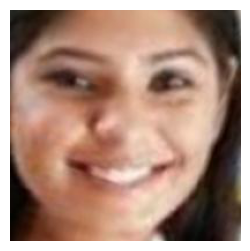

In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}
# Exploratory Data Analysis
from PIL import Image
img = Image.open(df['image'][2])
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

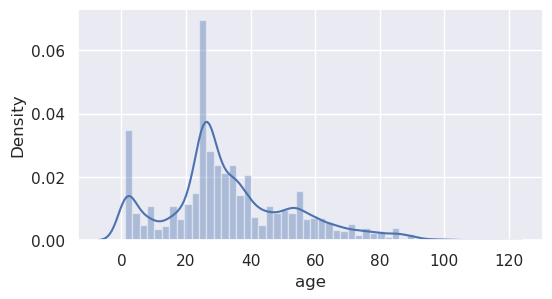

In [6]:
sns.set(rc={'figure.figsize':(6,3)})
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

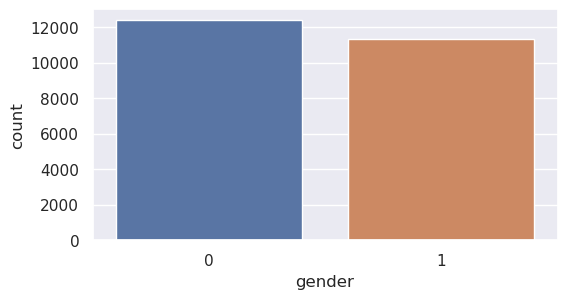

In [7]:
sns.set(rc={'figure.figsize':(6,3)})
sns.countplot(x = df['gender'])

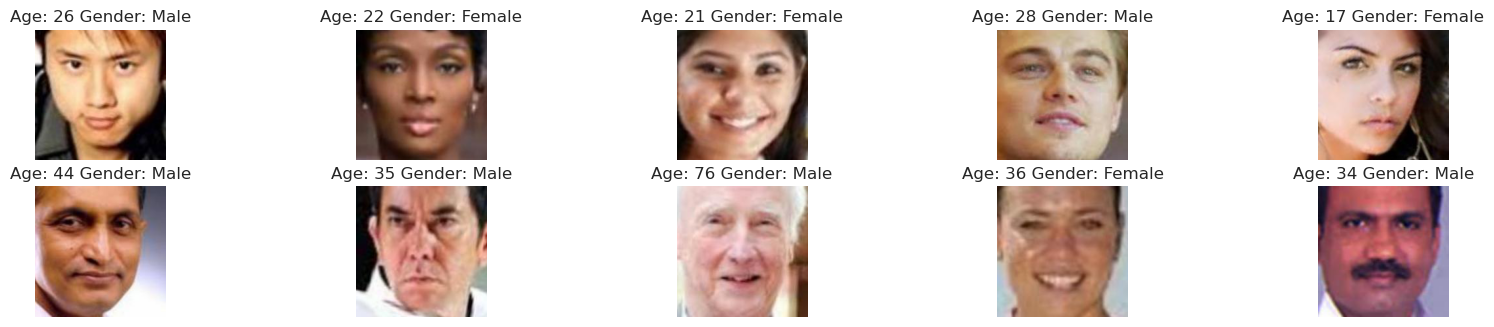

In [8]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(10, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
X.shape

(23708, 128, 128, 1)

In [12]:
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (128, 128, 1)

**Model Building**

In [13]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [15]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,min_delta=0.0001)

callbacks_list=[early_stopping,reduce_learningrate]

**Training**

In [16]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=16, epochs=30, validation_split=0.2,callbacks = callbacks_list)

Epoch 1/30
1186/1186 [==============================] - 22s 11ms/step - loss: 15.0506 - gender_out_loss: 0.6431 - age_out_loss: 14.4076 - gender_out_accuracy: 0.6070 - age_out_accuracy: 0.0442 - val_loss: 11.8353 - val_gender_out_loss: 0.5222 - val_age_out_loss: 11.3131 - val_gender_out_accuracy: 0.7493 - val_age_out_accuracy: 0.0268 - lr: 0.0010
Epoch 2/30
1186/1186 [==============================] - 13s 11ms/step - loss: 11.0285 - gender_out_loss: 0.4631 - age_out_loss: 10.5654 - gender_out_accuracy: 0.7818 - age_out_accuracy: 0.0178 - val_loss: 9.6804 - val_gender_out_loss: 0.4211 - val_age_out_loss: 9.2593 - val_gender_out_accuracy: 0.8020 - val_age_out_accuracy: 0.0099 - lr: 0.0010
Epoch 3/30
1186/1186 [==============================] - 12s 10ms/step - loss: 9.7109 - gender_out_loss: 0.3942 - age_out_loss: 9.3168 - gender_out_accuracy: 0.8175 - age_out_accuracy: 0.0100 - val_loss: 8.6153 - val_gender_out_loss: 0.3692 - val_age_out_loss: 8.2461 - val_gender_out_accuracy: 0.8275 - v

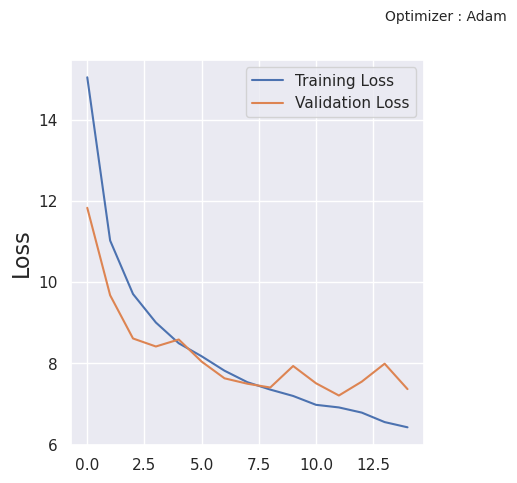

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.suptitle('Optimizer : Adam', fontsize = 10)
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')

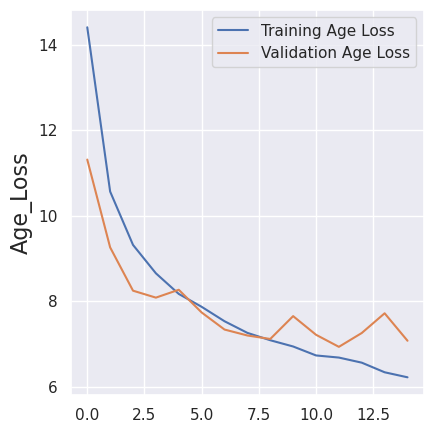

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plt.suptitle('Optimizer : Adam', fontsize = 10)
plt.ylabel('Age_Loss',fontsize=16)
plt.plot(history.history['age_out_loss'], label='Training Age Loss')
plt.plot(history.history['val_age_out_loss'],label='Validation Age Loss')
plt.legend(loc='upper right')

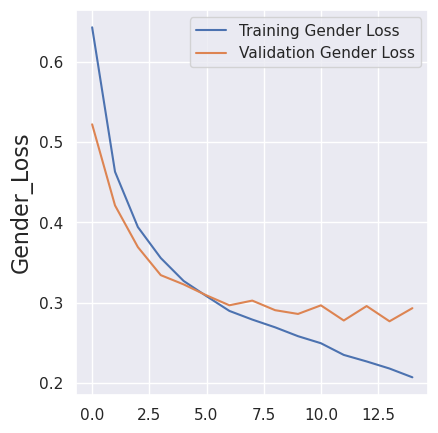

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plt.suptitle('Optimizer : Adam', fontsize = 10)
plt.ylabel('Gender_Loss',fontsize=16)
plt.plot(history.history['gender_out_loss'], label='Training Gender Loss')
plt.plot(history.history['val_gender_out_loss'],label='Validation Gender Loss')
plt.legend(loc='upper right')

Original Gender: Female Original Age: 18
1/1 [==============================] - 0s 155ms/step
Predicted Gender: Female Predicted Age: 19


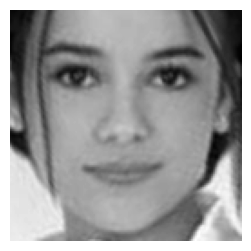

In [20]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [21]:
path = '/kaggle/input/utkface-new/crop_part1/13_1_0_20170109204108601.jpg.chip.jpg'
img = load_img(path, grayscale=True)
img = img.resize((128, 128), Image.ANTIALIAS)
img = np.array(img)
img = img/255.0
img = img.reshape(128,128,1)

1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: 21


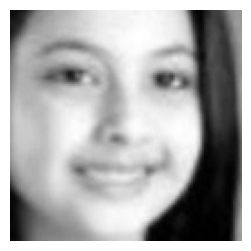

In [22]:
pred = model.predict(img.reshape(1,128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(img, cmap='gray');

**Testing on other dataset**

In [23]:
pred_dir ='/kaggle/input/utkface-new/crop_part1' 
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(pred_dir)):
    image_path = os.path.join(pred_dir, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [24]:
pred_df = pd.DataFrame()
pred_df['image'], pred_df['age'], pred_df['gender'] = image_paths, age_labels, gender_labels
pred_df.head()

,image,age,gender
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26,0
1,/kaggle/input/utkface-new/crop_part1/21_1_3_20...,21,1
2,/kaggle/input/utkface-new/crop_part1/17_1_4_20...,17,1
3,/kaggle/input/utkface-new/crop_part1/76_0_0_20...,76,0
4,/kaggle/input/utkface-new/crop_part1/18_1_0_20...,18,1


In [25]:
X_test = extract_features(pred_df['image'])

  0%|          | 0/9780 [00:00<?, ?it/s]

In [26]:
X_test = X_test/255.0
test_gender = np.array(pred_df['gender'])
test_age = np.array(pred_df['age'])

In [27]:
X_test.shape

(9780, 128, 128, 1)

In [28]:
pred = model.predict(X_test)
pred_gender = pred[0]
pred_age = pred[1]

306/306 [==============================] - 1s 4ms/step


In [29]:
pred_df['pred_gen'] = pred[0]
pred_df['pred_age'] = pred[1]
pred_df.head()

,image,age,gender,pred_gen,pred_age
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26,0,0.013211,24.978432
1,/kaggle/input/utkface-new/crop_part1/21_1_3_20...,21,1,0.885602,19.693228
2,/kaggle/input/utkface-new/crop_part1/17_1_4_20...,17,1,0.995540,24.650141
3,/kaggle/input/utkface-new/crop_part1/76_0_0_20...,76,0,0.082807,77.924980
4,/kaggle/input/utkface-new/crop_part1/18_1_0_20...,18,1,0.994986,18.749416


In [30]:
pred_df['pred_gen'] = pred_df['pred_gen'].map(lambda x:round(x))
pred_df.head()

,image,age,gender,pred_gen,pred_age
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26,0,0,24.978432
1,/kaggle/input/utkface-new/crop_part1/21_1_3_20...,21,1,1,19.693228
2,/kaggle/input/utkface-new/crop_part1/17_1_4_20...,17,1,1,24.650141
3,/kaggle/input/utkface-new/crop_part1/76_0_0_20...,76,0,0,77.924980
4,/kaggle/input/utkface-new/crop_part1/18_1_0_20...,18,1,1,18.749416


In [31]:
pred_gen = pred_df['pred_gen'].values
gen = pred_df['gender'].values
pred_age = pred_df['pred_age'].values
age = pred_df['age'].values

In [32]:
from sklearn.metrics import accuracy_score, r2_score
acc_gender = accuracy_score(pred_gen,gen)
acc_age = r2_score(pred_age,age)
print(acc_gender)
print(acc_age)

0.8600204498977505
0.8365931799895122
